In [ ]:
import numpy
import pandas as pd 
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

## Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers (4).csv


In [ ]:
import io
data = pd.read_csv(io.StringIO(uploaded['AirPassengers.csv'].decode('utf-8')))

**Sample of the first few lines of the file.**

In [ ]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


**Sample of the last few lines of the file.**

In [ ]:
data.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


**Upward trend in the dataset over time.**

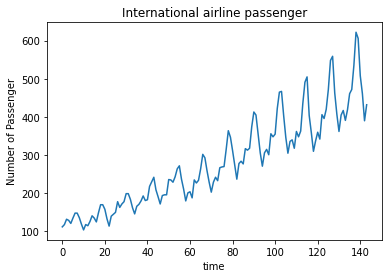

In [ ]:
import matplotlib.pyplot as plt
data.rename(columns={'#Passengers':'passengers'},inplace=True)
dataset = data.iloc[:,1].values
plt.plot(dataset)
plt.xlabel("time")
plt.ylabel("Number of Passenger")
plt.title("International airline passenger")
plt.show()

## Preprocessing

**Now we can look at the summary of the data set**

In [ ]:
data.info()
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


(144, 1)

**We scale the data between 0 and 1 for our LSTM model.We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.We need to scale the data for all deep learning models.**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
dataset=scaler.fit_transform(dataset)

**We splitted the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 69.4% of the observations that we can use to train our model, leaving the remaining 30.5% for testing the model.**

In [ ]:
train_size = 100
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 100, test size: 44 


In [ ]:
train.shape

(100, 1)

In [ ]:
test.shape

(44, 1)

**We use default value 1 of time_stemp and use numpy for the array we want to convert to dataset.**

**X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).**

In [ ]:
def get_data(data, time_stemp):
    dataX, dataY = [], []
    for i in range(len(data)-time_stemp-1):
        a = data[i:(i+time_stemp), 0]
        dataX.append(a)
        dataY.append(data[i+time_stemp, 0])
    return np.array(dataX), np.array(dataY)

**Let’s use this function to prepare the train and test datasets for modeling.**

In [ ]:
import numpy as np
time_stemp = 1
X_train, y_train = get_data(train, time_stemp)
X_test, y_test = get_data(test, time_stemp)

In [ ]:
X_train.shape

(98, 1)

**Currently, our data is; examples and features. We can transform the prepared train and test input data into the expected structure using reshape() as follows:**

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [ ]:
X_train.shape

(98, 1, 1)

In [ ]:

type(y_test)

numpy.ndarray

## Build LSTM Model

**Our model consists of a 5-node LSTM layer and a one-node Dense layer as the output layer. We use Adam as the optimizer and mean squares error as the loss method. Our model is trained for 25 epochs and 1 batch size is used**

In [ ]:
model = Sequential()
model.add(LSTM(5, input_shape = (1, time_stemp)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=25, batch_size=1)

Epoch 1/25
98/98 [==============================] - 2s 2ms/step - loss: 0.0370
Epoch 2/25
98/98 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 3/25
98/98 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 4/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 5/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 6/25
98/98 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 7/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 8/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 9/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 10/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 11/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 12/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 13/25
98/98 [==============================

## Prediction
**After training our model, we prediction our test set and store it.**

In [ ]:
y_pred = model.predict(X_test)

**We scale the data with scaler and then use the inverse for prediction**

In [ ]:
scaler.scale_

array([0.0019305], dtype=float32)

In [ ]:
y_pred = scaler.inverse_transform(y_pred)

**We reshaped due to unknown number of rows**

In [ ]:
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

**Here is the real number of passengers**

In [ ]:
y_test.view()

array([[421.99997],
       [465.     ],
       [466.99997],
       [403.99997],
       [347.     ],
       [305.     ],
       [336.     ],
       [340.     ],
       [318.     ],
       [362.     ],
       [348.     ],
       [363.     ],
       [434.99997],
       [491.     ],
       [505.     ],
       [403.99997],
       [359.     ],
       [310.     ],
       [337.     ],
       [360.     ],
       [342.     ],
       [406.     ],
       [395.99997],
       [420.     ],
       [471.99997],
       [548.     ],
       [559.     ],
       [462.99997],
       [407.     ],
       [362.     ],
       [404.99997],
       [416.99997],
       [390.99997],
       [418.99997],
       [461.     ],
       [471.99997],
       [535.     ],
       [622.     ],
       [606.     ],
       [507.99997],
       [461.     ],
       [390.     ]], dtype=float32)

**Here is prediced number of passengers**

In [ ]:
y_pred.view()

array([[345.5842 ],
       [410.1696 ],
       [450.5858 ],
       [452.43918],
       [392.9724 ],
       [337.795  ],
       [296.8408 ],
       [327.07297],
       [330.97314],
       [309.5154 ],
       [352.3914 ],
       [338.76917],
       [353.36304],
       [422.4955 ],
       [474.47092],
       [487.1343 ],
       [392.9724 ],
       [349.4751 ],
       [301.7141 ],
       [328.04816],
       [350.44736],
       [332.92276],
       [394.89008],
       [385.28625],
       [408.266  ],
       [457.06113],
       [525.0728 ],
       [534.5311 ],
       [448.7299 ],
       [395.84824],
       [352.3914 ],
       [393.9314 ],
       [405.407  ],
       [380.4706 ],
       [407.31345],
       [446.8715 ],
       [457.06113],
       [513.762  ],
       [586.6108 ],
       [573.73065],
       [489.8288 ],
       [446.8715 ]], dtype=float32)

# **Plot of prediction of one data point ahead**

**As can be seen in the plot, one step prediction is not bad. 
The scale is a bit of, because the data is normalized.**

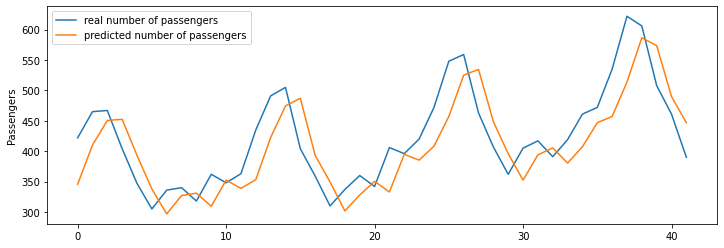

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(12,4))
plt.plot(y_test, label = 'real number of passengers')
plt.plot(y_pred, label = 'predicted number of passengers')
plt.ylabel('Passengers')
plt.legend()
plt.show()

##Conclusion
**As can be seen in the table formed according to the results, according to these data between the years 1949-1960, we see that the number of passengers fluctuated as time progressed, not in a constant increasing or decreasing state. However, our model predicted these fluctuations and managed to make on-the-spot predictions. This result clearly shows how powerful LSTM is in data analysis.**